# Rate of assignments assigned per week over the year (especially in March)

In [6]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as ticker
import json
import sys
sys.path.insert(0, '/home/jenny/remote_learning_code_Spring_2017-2020')
from utils import parse_args


sys.argv = ['-f']
args = parse_args()

term_20 = args.semester_2020_Spring
start_date_20 = args.start_date_2020_Spring
remote_date_20 = args.remote_date_2020_Spring
end_date_20 = args.end_date_2020_Spring

term_19 = args.semester_2019_Spring
start_date_19 = args.start_date_2019_Spring
cutoff_date_19 = args.cutoff_date_2019_Spring
end_date_19 = args.end_date_2019_Spring

term_18 = args.semester_2018_Spring
start_date_18 = args.start_date_2018_Spring
cutoff_date_18 = args.cutoff_date_2018_Spring
end_date_18 = args.end_date_2018_Spring

term_17 = args.semester_2017_Spring
start_date_17 = args.start_date_2017_Spring
cutoff_date_17 = args.cutoff_date_2017_Spring
end_date_17 = args.end_date_2017_Spring

f = open('../assignment_with_submission.json',)
assignments_with_submission = json.load(f)['assignment_id']

In [19]:
def process_assignments(term, assignments_file, assignments_overrides_file):
    # load assignments
    assignments = pd.read_csv(assignments_file, sep='\t', header=0)
    #if term != term_20 or (term == term_20 and assignments_file == args.assignments):
    assignments = assignments.loc[assignments['term_name']==term]
    assignments = assignments.loc[assignments['assignment_id'].isin(assignments_with_submission), ['assignment_id', 'asn_created_at', 'asn_unlock_at', 'asn_due_at']]  # no duplicate exists

    # load assignments overrides
    assignments_overrides = pd.read_csv(assignments_overrides_file, sep='\t', header=0)
    assignments_overrides = assignments_overrides.loc[assignments_overrides['term_name']==term]
    assignments_overrides = assignments_overrides.loc[assignments_overrides['due_at'].notnull(), ['assignment_id', 'due_at', 'unlock_at']].drop_duplicates()
    assignments = pd.merge(assignments, assignments_overrides, on='assignment_id', how='left')
    assignments['new_due_at'] = assignments[['asn_due_at', 'due_at']].apply(lambda x: x['asn_due_at'] if pd.isnull(x['due_at']) else x['due_at'], axis=1)
    assignments['asn_created_at'] = pd.to_datetime(assignments['asn_created_at'], format='%Y-%m-%d %H:%M:%S.%f')
    assignments['asn_unlock_at'] = assignments[['asn_unlock_at', 'unlock_at']].apply(lambda x: x['asn_unlock_at'] if pd.isnull(x['unlock_at']) else x['unlock_at'], axis=1)
    assignments['asn_unlock_at'] = pd.to_datetime(assignments['asn_unlock_at'], format='%Y-%m-%d %H:%M:%S.%f')
    assignments['new_due_at'] = pd.to_datetime(assignments['new_due_at'], format='%Y-%m-%d %H:%M:%S.%f')
    return assignments

In [20]:
assignments_20 = process_assignments(term_20, args.assignments, args.assignments_overrides)
assignments_19 = process_assignments(term_19, args.assignments, args.assignments_overrides)
assignments_18 = process_assignments(term_18, args.assignments, args.assignments_overrides)
assignments_17 = process_assignments(term_17, args.assignments, args.assignments_overrides)

In [23]:
def unlock_group(assignments, start_date, end_date):
    unlock = assignments.loc[(assignments['asn_unlock_at']>=start_date)&(assignments['asn_unlock_at']<=end_date), ['assignment_id', 'asn_unlock_at']].drop_duplicates()
    unlock['asn_unlock_at'] = unlock['asn_unlock_at'].apply(lambda x: x.date())
    unlock_group = unlock.groupby('asn_unlock_at').size().reset_index()
    return unlock_group

unlock_group_20 = unlock_group(assignments_20, start_date_20, end_date_20)
unlock_group_19 = unlock_group(assignments_19, start_date_19, end_date_19)
unlock_group_18 = unlock_group(assignments_18, start_date_18, end_date_18)
unlock_group_17 = unlock_group(assignments_17, start_date_17, end_date_17)

unlock_group_20.set_index('asn_unlock_at', inplace=True)
unlock_group_19['asn_unlock_at'] = unlock_group_19['asn_unlock_at'].apply(lambda x: x.replace(year=2020))
unlock_group_19.set_index('asn_unlock_at', inplace=True)
unlock_group_18['asn_unlock_at'] = unlock_group_18['asn_unlock_at'].apply(lambda x: x.replace(year=2020))
unlock_group_18.set_index('asn_unlock_at', inplace=True)
unlock_group_17['asn_unlock_at'] = unlock_group_17['asn_unlock_at'].apply(lambda x: x.replace(year=2020))
unlock_group_17.set_index('asn_unlock_at', inplace=True)

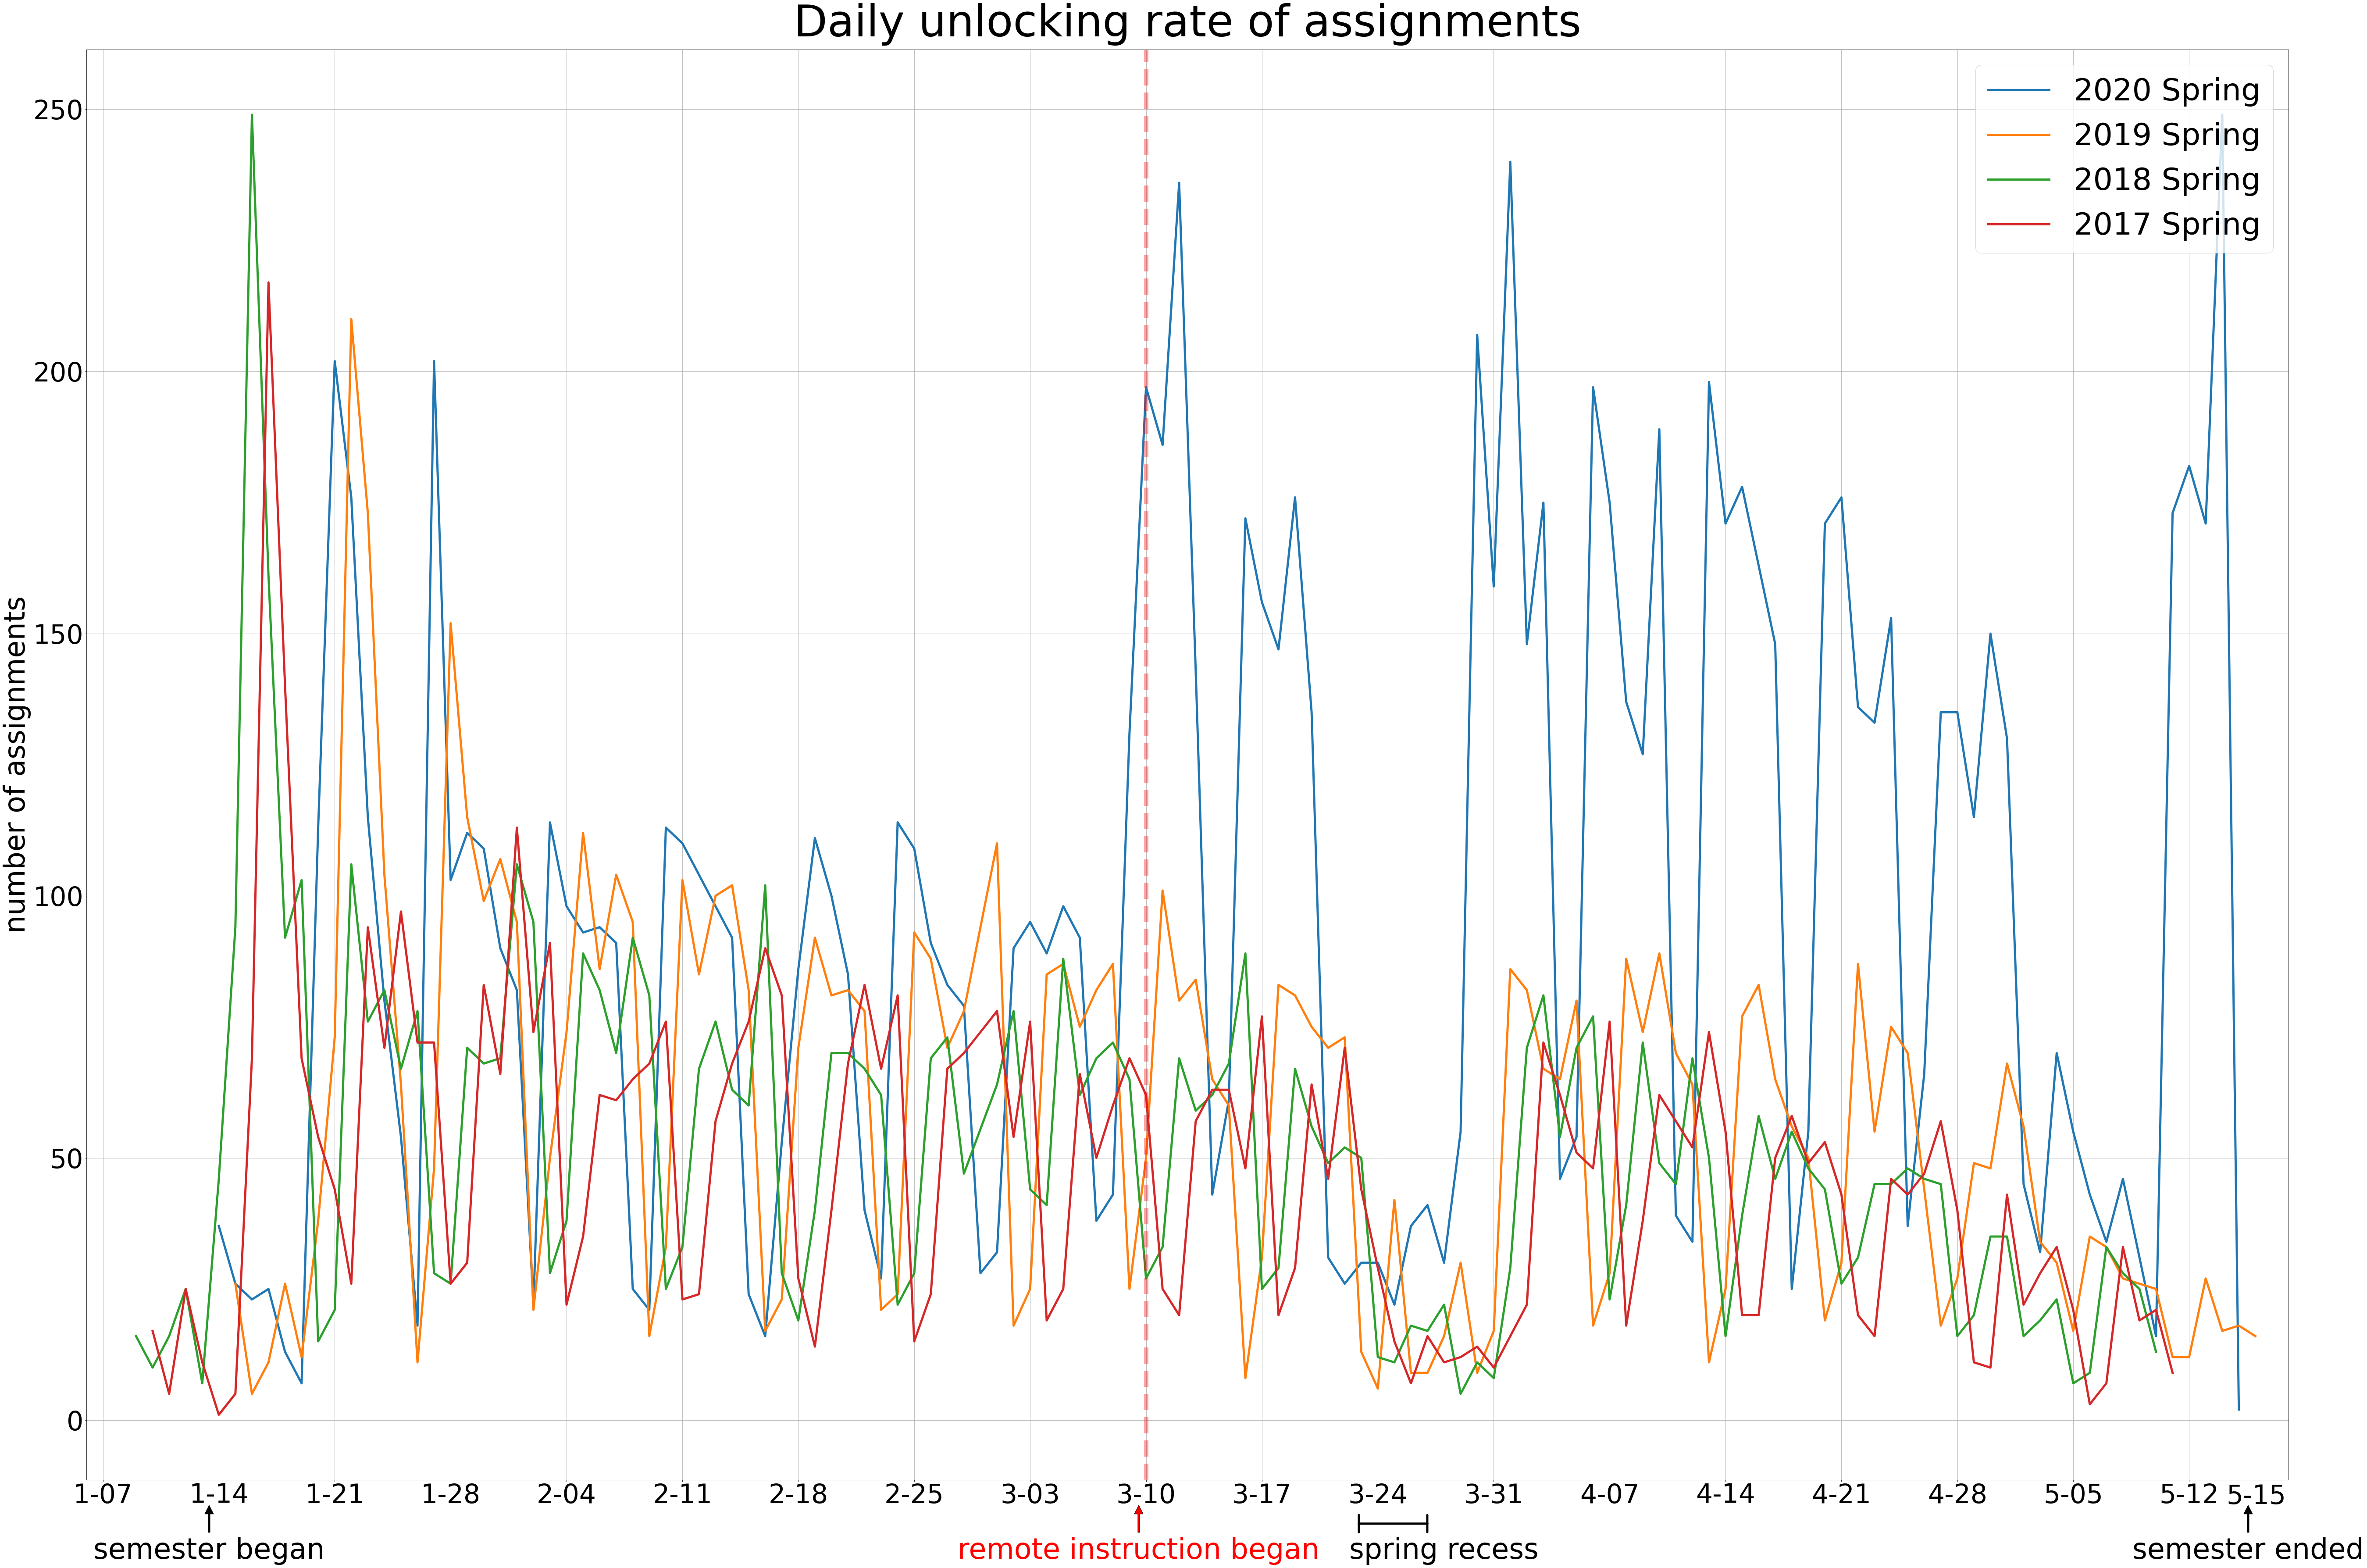

In [24]:
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')

# set x-axis ticks
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(unlock_group_20, linewidth=5.0, label='2020 Spring')
plt.plot(unlock_group_19, linewidth=5.0, label='2019 Spring')
plt.plot(unlock_group_18, linewidth=5.0, label='2018 Spring')
plt.plot(unlock_group_17, linewidth=5.0, label='2017 Spring')
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Daily unlocking rate of assignments', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of assignments', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
plt.legend(prop={'size': 70})
plt.show()

# line plot of number of unlocked assignments per day:

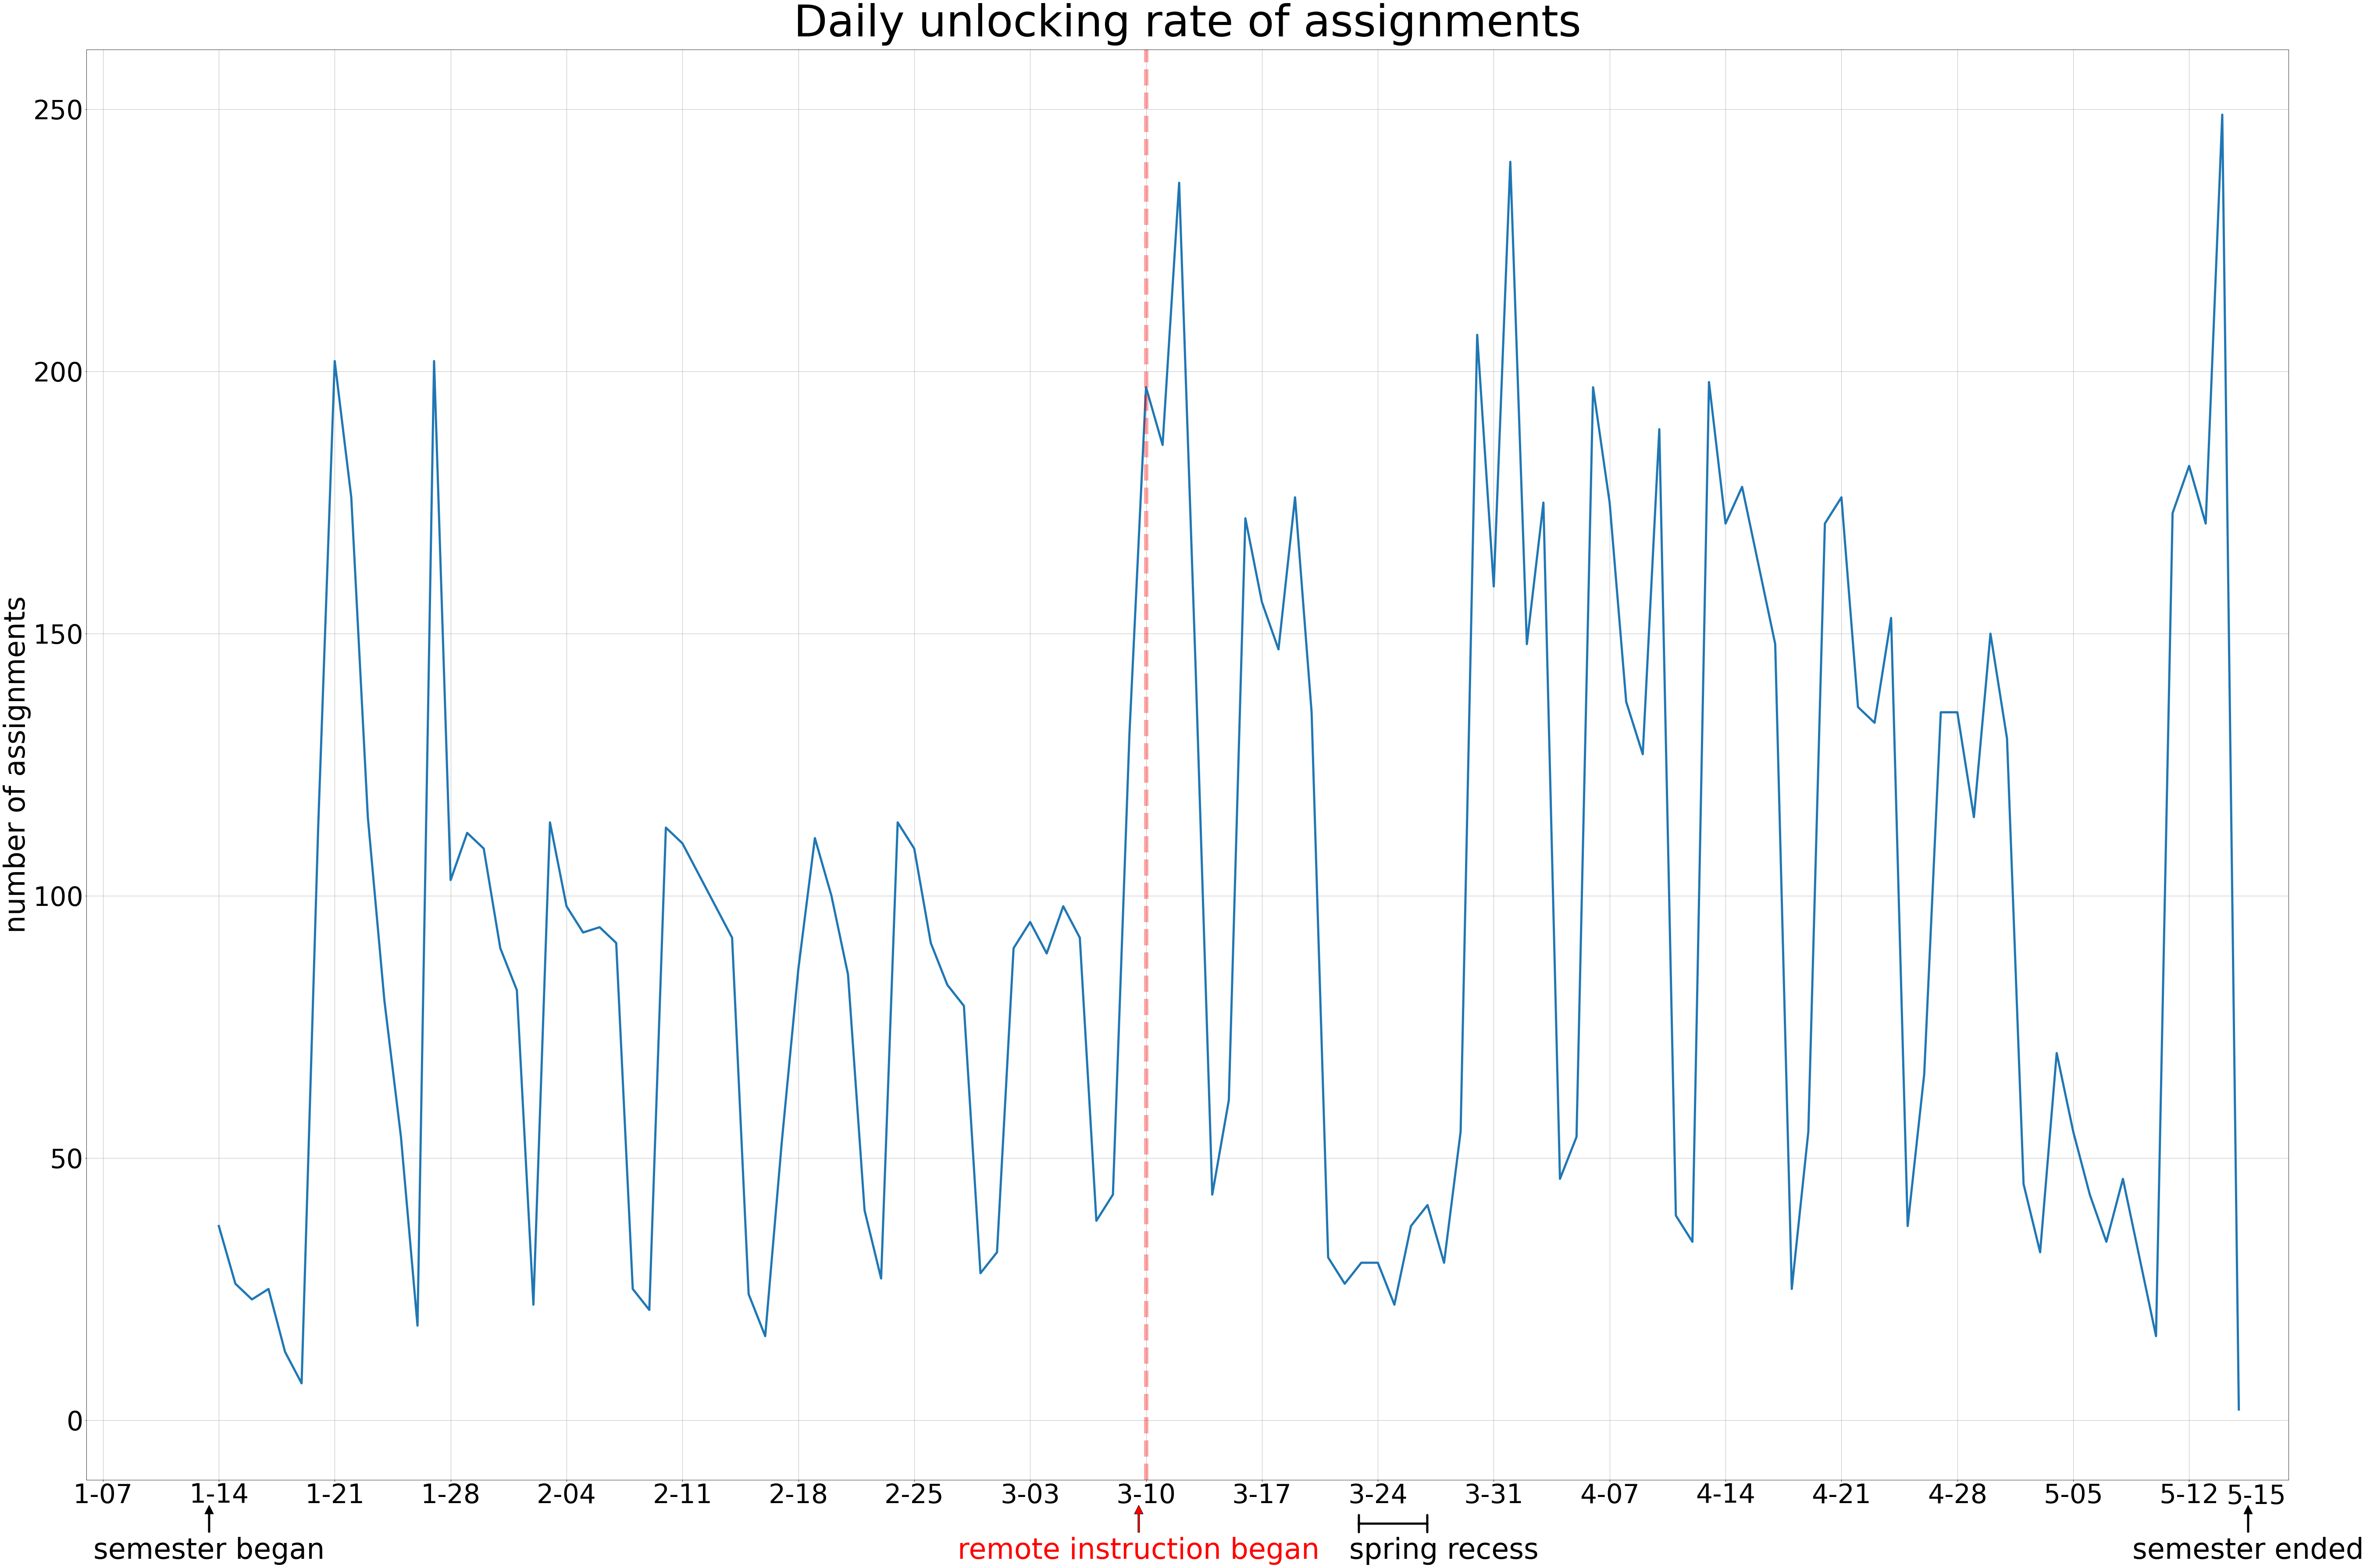

In [25]:
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')

# set x-axis ticks
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(unlock_group_20, linewidth=5.0, label='2020 Spring')
plt.plot(unlock_group_19, linewidth=5.0, label='2019 Spring', alpha=0)
plt.plot(unlock_group_18, linewidth=5.0, label='2018 Spring', alpha=0)
plt.plot(unlock_group_17, linewidth=5.0, label='2017 Spring', alpha=0)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Daily unlocking rate of assignments', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of assignments', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
#plt.legend(prop={'size': 70})
plt.show()

# line plot of number of unlocked assignments per day:

In [26]:
def due_group(assignments, start_date, end_date):
    due = assignments.loc[(assignments['new_due_at']>=start_date)&(assignments['new_due_at']<=end_date), ['assignment_id', 'new_due_at']].drop_duplicates()
    due['new_due_at'] = due['new_due_at'].apply(lambda x: x.date())
    due_group = due.groupby('new_due_at').size().reset_index()
    return due_group

due_group_20 = due_group(assignments_20, start_date_20, end_date_20)
due_group_19 = due_group(assignments_19, start_date_19, end_date_19)
due_group_18 = due_group(assignments_18, start_date_18, end_date_18)
due_group_17 = due_group(assignments_17, start_date_17, end_date_17)

due_group_20.set_index('new_due_at', inplace=True)
due_group_19['new_due_at'] = due_group_19['new_due_at'].apply(lambda x: x.replace(year=2020))
due_group_19.set_index('new_due_at', inplace=True)
due_group_18['new_due_at'] = due_group_18['new_due_at'].apply(lambda x: x.replace(year=2020))
due_group_18.set_index('new_due_at', inplace=True)
due_group_17['new_due_at'] = due_group_17['new_due_at'].apply(lambda x: x.replace(year=2020))
due_group_17.set_index('new_due_at', inplace=True)

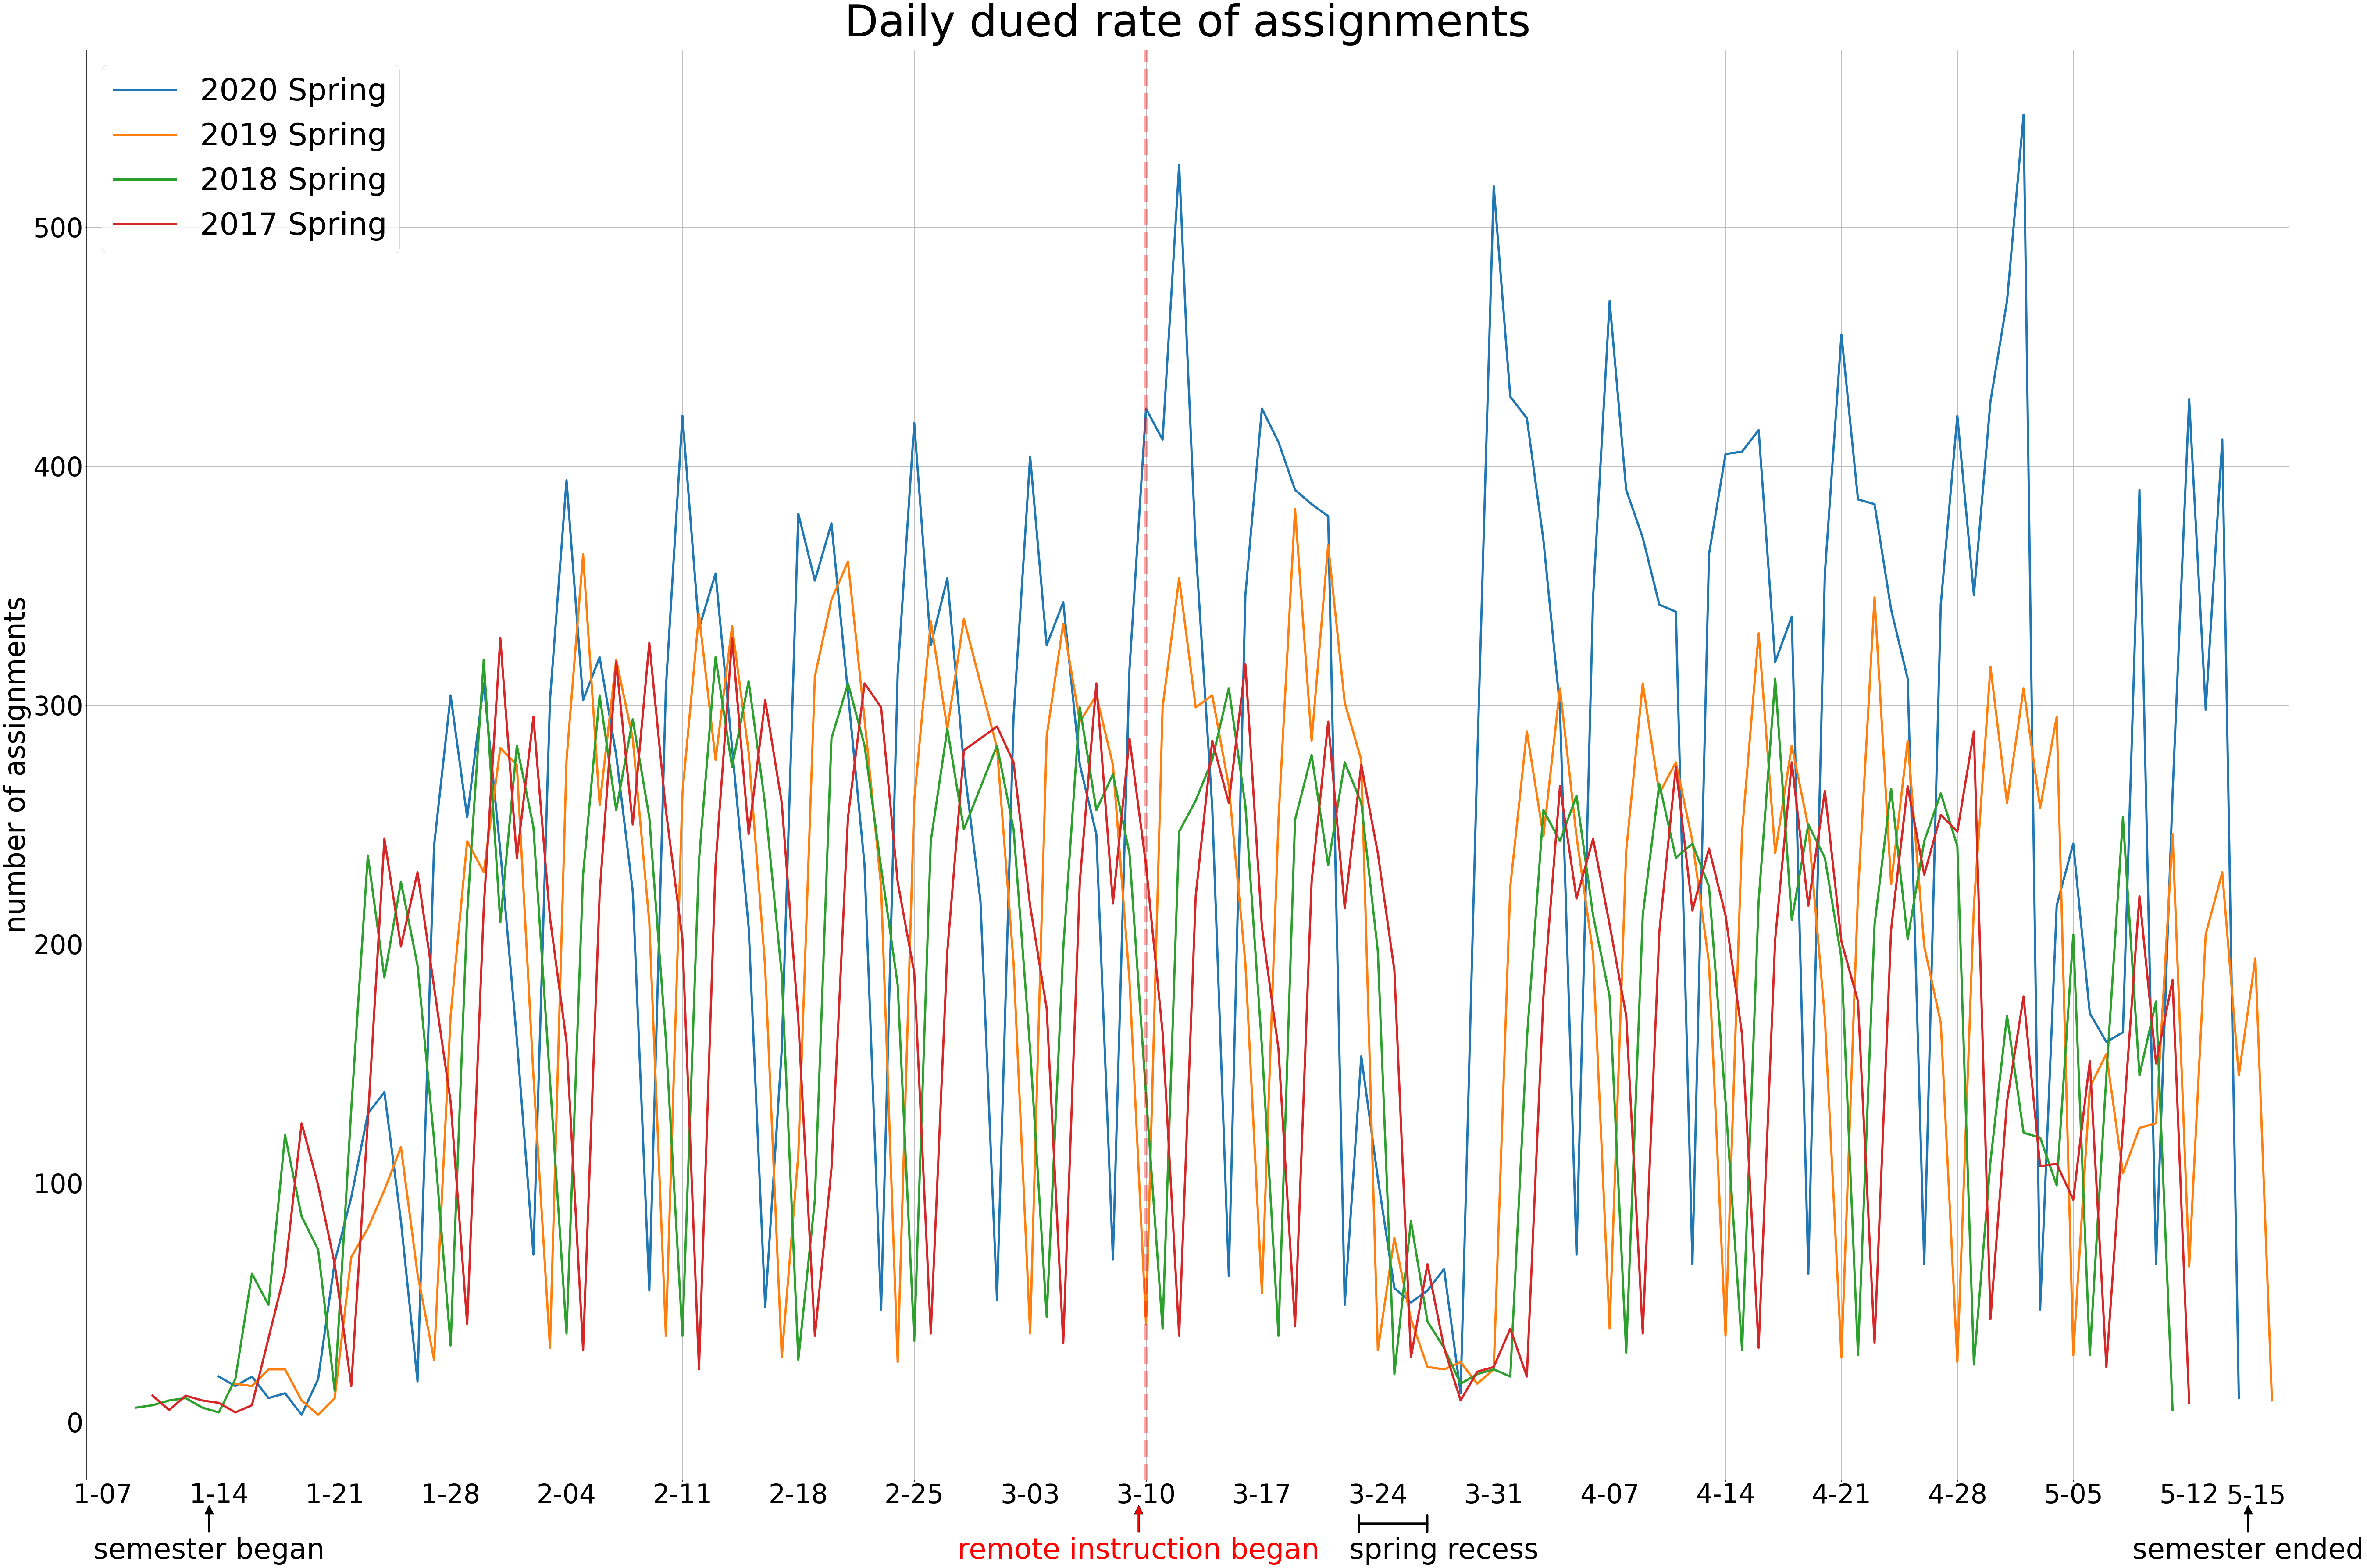

In [27]:

fig,ax = plt.subplots()
# set x-axis ticks
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(due_group_20, linewidth=5.0, label='2020 Spring')
plt.plot(due_group_19, linewidth=5.0, label='2019 Spring')
plt.plot(due_group_18, linewidth=5.0, label='2018 Spring')
plt.plot(due_group_17, linewidth=5.0, label='2017 Spring')
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Daily dued rate of assignments', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of assignments', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
plt.legend(prop={'size': 70})
plt.show()
# line plot of number of assignments that were due per day: